In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [235]:
dtype = {
    'rate-reason-deletions': 'Int64',
    'rate-RAT-introductions': 'Int64',
    'rate-RUP-introductions': 'Int64',
}
checkers = 'rate', 'rate-d', 'drat-trim', 'gratgen'
df = pd.read_csv('results.csv', dtype=dtype)

df['time-delta-rate-rate-d'] = df['rate-time'] - df['rate-d-time']
df['time-delta-percent-rate-rate-d'] = (df['rate-time'] - df['rate-d-time']) / df['rate-time']
df['space-delta-rate-rate-d'] = df['rate-space'] - df['rate-d-space']
df['space-delta-percent-rate-rate-d'] = (df['rate-space'] - df['rate-d-space']) / df['rate-space']
df['rate-reason-deletions-not-shrinking-trail'] = (df['rate-reason-deletions'] -
   df['rate-reason-deletions-shrinking-trail'])

verified = 'verified'
verified = 'lrat-check pending' # not run again

df['space-delta-rate-drat-trim'] = df['rate-space'] - df['drat-trim-space']

vf = df[ (df['rate-result'] == verified)
         & (df['rate-d-result'] == verified)
         & (df['drat-trim-result'] == verified)
         & (df['gratgen-result'] == 'verified')
]
rvf = df[ (df['rate-result'] == verified) & (df['rate-d-result'] == verified) ]


In [236]:
checkers = 'rate', 'rate-d', 'drat-trim', 'gratgen'
LABELS = {
    'space': 'memory usage (MB)',
    'time': 'runtime (s)',
    'rate-reason-deletions': 'reason deletions',
    'rate-reason-deletions-shrinking-trail': 'non-redundant reason deletions',
    'rate-reason-deletions-not-shrinking-trail': 'redundant reason deletions',
}
COLORS = {
    'rate': 'red',
    'rate-d': 'orange',
    'drat-trim': 'darkcyan',
    'gratgen': 'blue',
}
MARKERS = {
    'rate': '1',
    'rate-d': '2',
    'drat-trim': '3',
    'gratgen': '4',
}

for c1 in checkers:
    LABELS[f'{c1}-time'] = f'{c1} runtime (s)'
    LABELS[f'{c1}-space'] = f'{c1} memory usage (MB)'
    for c2 in checkers:
        LABELS[f'time-delta-{c1}-{c2}'] = f'runtime overhead of {c1} compared to {c2}'
        LABELS[f'time-delta-percent-{c1}-{c2}'] = f'ratio of runtime overhead of {c1} compared to {c2}'
        LABELS[f'space-delta-{c1}-{c2}'] = f'memory usage overhead of {c1} compared to {c2}'
        LABELS[f'space-delta-percent-{c1}-{c2}'] = f'ratio of memory usage overhead of {c1} compared to {c2}'

def sort_by_col(df, col):
    tmp = df.sort_values(col)
    tmp['index'] = np.arange(len(tmp))
    return tmp

def set_labels(ax, x=None, y=None):
    if x is not None:
        ax.set_xlabel(LABELS[x])
    if y is not None:
        ax.set_ylabel(LABELS[y])

def boxplot(df, y, cs=checkers, **kwargs):
    ax = df[[f'{checker}-{y}' for checker in checkers]].boxplot()
    set_labels(ax, y=y)

def compare(df, y, cs=checkers, **kwargs):
    ax = plt.subplot()
    x = list(range(len(df)))
    for checker in cs:
        sort_by_col(df, f'{checker}-{y}').plot(x='index', y=f'{checker}-{y}', ax=ax, \
                                               kind='scatter', marker=MARKERS[checker],
                                               color=COLORS[checker], label=checker, **kwargs)
    ax.legend(loc='upper left')
    plt.xlabel('proofs verified by all checkers')
    set_labels(ax, y=y)

def crossplot(df, x, y):
    limit = max(df[x].max(), df[y].max()) * 1.02
    ax = df.plot(x, y, kind='scatter', marker='1', xlim=(0, limit), ylim=(0, limit))
    ax.plot((0, limit), (0, limit), color='green', linestyle='dashed', linewidth=1)
    set_labels(ax, x, y)

def correlation(df, x, y, **kwargs):
    ax = plt.subplot()
    rvf.plot(x, y, ax=ax, kind='scatter', marker='3', **kwargs);
    limit = df[x].max()
    ax.plot((0, limit), (0, 0), color='green', linestyle='dashed', linewidth=1)
    set_labels(ax, x, y)

SAVE_FIGURES = 1
def persist(name, needPDF=True, needSVG=False, needPNG=False):
    if SAVE_FIGURES:
        if needPDF: plt.savefig(f'p/{name}.pdf')
        if needSVG: plt.savefig(f'p/{name}.svg')
        if needPNG: plt.savefig(f'p/{name}.png')

In [264]:
vf[[f'{checker}-time' for checker in checkers]].describe()

,rate-time,rate-d-time,drat-trim-time,gratgen-time
count,192.000000,192.000000,192.000000,192.000000
mean,859.895938,849.064062,1003.563229,657.866823
std,1319.393650,1298.585356,1659.624827,1060.808083
min,0.630000,0.550000,0.450000,0.310000
25%,41.220000,42.362500,28.835000,25.295000
50%,336.285000,336.090000,387.345000,254.315000
75%,1018.640000,1021.682500,1095.005000,774.945000
max,7491.320000,7495.090000,11198.030000,7041.430000


In [240]:
outliers = []
# rate-d high time
outliers += [vf['rate-d-time'].idxmax()]

In [241]:
# high memory usage
outliers += [vf['rate-space'].idxmax()]

In [242]:
# many reason deletions
outliers += [vf['rate-reason-deletions'].map(int).idxmax()]

In [243]:
outliers += [vf['space-delta-rate-rate-d'].idxmax()]

In [244]:
for outlier in outliers:
    row = vf.loc[outlier]
    print(f'{row.instance}/{row.solver}')

by-X-2-7-100/CaDiCaL@DONTUNZIP-fixed
cms-scheel-md5-families-r24-c5-p6-11-15-16-19/Minisat-v2.2.0-106-ge2dd095@simp_proof
Problem14_label19_true-unreach-call.c/Sparrow2Riss-2018-fixfix@MAIN
T129.2.0/Riss7.1-fix@BVE_DRAT


In [245]:
vf.columns

Index(['instance', 'solver', 'stime', 'sresult', 'rate-result', 'rate-time',
       'rate-space', 'rate-solution', 'rate-verified', 'rate-reason-deletions',
       'rate-reason-deletions-shrinking-trail', 'rate-RAT-introductions',
       'rate-RUP-introductions', 'rate-d-result', 'rate-d-time',
       'rate-d-space', 'rate-d-solution', 'rate-d-verified',
       'rate-d-reason-deletions', 'gratgen-result', 'gratgen-time',
       'gratgen-space', 'gratgen-solution', 'gratgen-verified',
       'drat-trim-result', 'drat-trim-time', 'drat-trim-space',
       'drat-trim-solution', 'drat-trim-verified', 'time-delta-rate-rate-d',
       'time-delta-percent-rate-rate-d', 'space-delta-rate-rate-d',
       'space-delta-percent-rate-rate-d',
       'rate-reason-deletions-not-shrinking-trail',
       'space-delta-rate-drat-trim'],
      dtype='object')

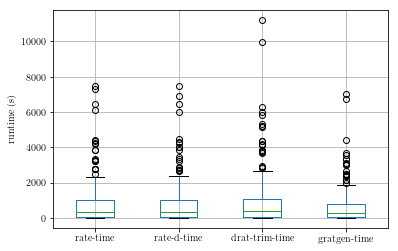

In [246]:
boxplot(vf, 'time'); persist('box-time')

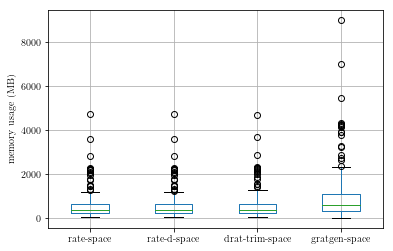

In [247]:
boxplot(vf, 'space'); persist('box-space')

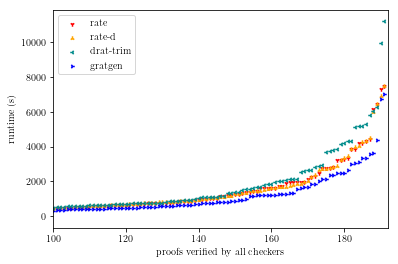

In [250]:
compare(vf, 'time', xlim=(100, len(vf))); persist('cactus-time')


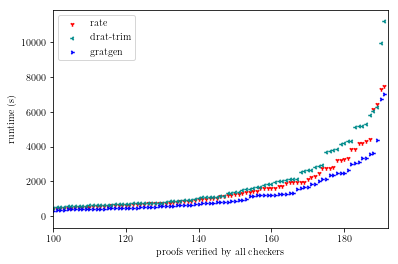

In [251]:
compare(vf, 'time', xlim=(100, len(vf)), cs=('rate', 'drat-trim', 'gratgen')); persist('cactus-time3')

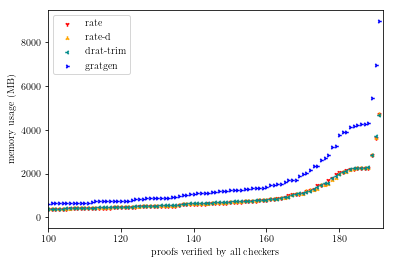

In [252]:
compare(vf, 'space', xlim=(100, len(vf))); persist('cactus-space')

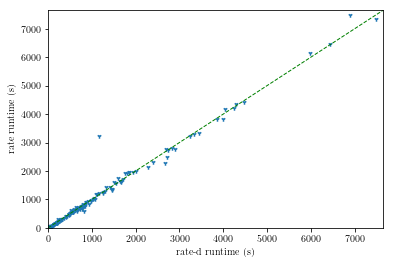

In [253]:
crossplot(vf, 'rate-d-time', 'rate-time'); persist('cross-rate-d-rate')

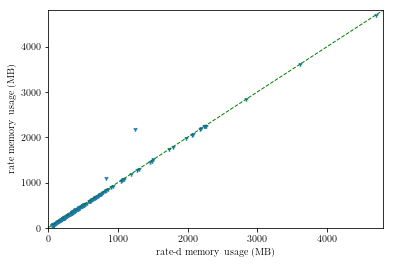

In [254]:
crossplot(vf, 'rate-d-space', 'rate-space');

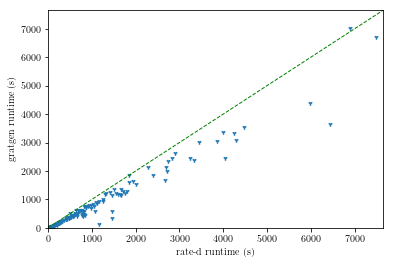

In [255]:
crossplot(vf, 'rate-d-time', 'gratgen-time'); persist('cross-rate-d-gratgen')

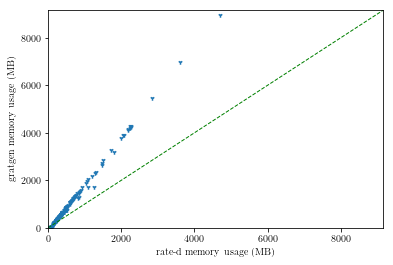

In [256]:
crossplot(vf, 'rate-d-space', 'gratgen-space');

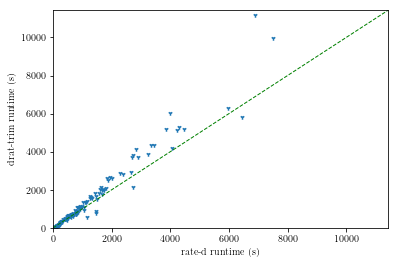

In [257]:
crossplot(vf, 'rate-d-time', 'drat-trim-time'); persist('cross-rate-d-drat-trim')

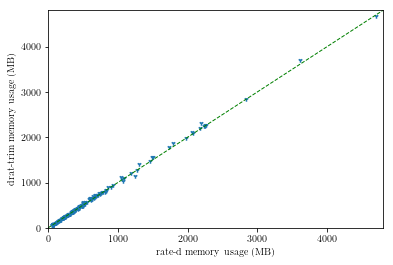

In [258]:
crossplot(vf, 'rate-d-space', 'drat-trim-space');

# Correlation

In [259]:
# correlation(rvf, 'rate-reason-deletions', 'time-delta-rate-rate-d'); persist('correlation-reason-deletions-time-delta')

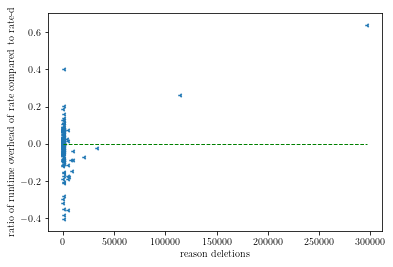

In [260]:
correlation(rvf, 'rate-reason-deletions', 'time-delta-percent-rate-rate-d'); persist('correlation-reason-deletions-time-delta-percent')

In [261]:
# correlation(rvf, 'rate-reason-deletions', 'space-delta-rate-rate-d'); persist('correlation-reason-deletions-space-delta')

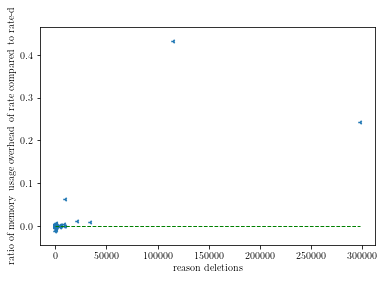

In [262]:
correlation(rvf, 'rate-reason-deletions', 'space-delta-percent-rate-rate-d'); persist('correlation-reason-deletions-space-delta-percent')

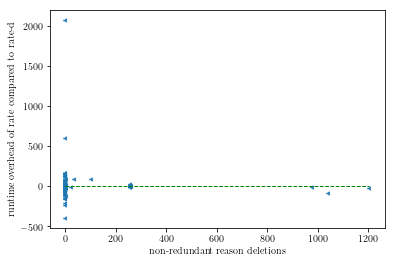

In [263]:
 correlation(rvf, 'rate-reason-deletions-shrinking-trail', 'time-delta-rate-rate-d')